In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

In [ ]:
%%time

df = pd.read_csv('data/examples_with_length_speech2vec_vocab.csv')
df.shape

In [ ]:
%%time
fn2features = pd.read_pickle('data/fn2feature.pkl')

In [ ]:
df = df[((df.source_length < 70) & (df.target_length < 70) & (df.source_length > 25) & (df.target_length > 25))]
df = df[df.in_speech2vec_vocab]
df.reset_index(drop=True, inplace=True)

In [ ]:
vocab = list(df.source_word.unique())

In [ ]:
len(vocab)

In [ ]:
df.head()

In [ ]:
dataset_mean = -3
dataset_std = 12

def normalize_data(ary):
    return (ary - dataset_mean) / dataset_std

In [ ]:
def empty_list(): return list()

In [ ]:
# %%time

# word2row_idxs = defaultdict(empty_list)

# for idx, row in df.iterrows():
#     word2row_idxs[row.source_word].append(idx)
    
# pd.to_pickle(word2row_idxs, 'data/word2row_idxs_speech2vec_vocab_subset.pkl')

In [ ]:
word2row_idxs = pd.read_pickle('data/word2row_idxs_speech2vec_vocab_subset.pkl')

In [ ]:
def prepare_features(fn, pad_to=69):
    ary = fn2features[fn][:pad_to]
    example = np.zeros((pad_to, 13))
    example[:ary.shape[0], :] = ary
    return example.astype(np.float32)

In [ ]:
if np.nan in vocab: vocab.remove(np.nan)

In [ ]:
class Dataset():
    def __init__(self, n):
        self.vocab = vocab * n
    def __len__(self):
        return len(self.vocab)
    def __getitem__(self, idx):
        row_idx = np.random.randint(len(word2row_idxs[self.vocab[idx]]))
        source_fn = df.source_fn[row_idx]
        target_fn = df.target_fn[row_idx]
        x = normalize_data(prepare_features(source_fn)).transpose(1, 0)
        y = normalize_data(prepare_features(target_fn)).transpose(1, 0)
        return x, y
#         return np.stack((x, y)), y

In [ ]:
BS = 32
LR = 1e-3
NUM_WORKERS = 8

train_dl = DataLoader(Dataset(10*270), BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(Dataset(30), BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
# Got the following error while training:

# DataLoader worker (pid 2073) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.
# trying the solution I found here: https://github.com/pytorch/pytorch/issues/5040
# which is to execute
!sudo umount /dev/shm/ && sudo mount -t tmpfs -o rw,nosuid,nodev,noexec,relatime,size=50G shm /dev/shm

In [ ]:
# bidirectional encoder, 1 layer, concatenate hidden state
class Model(Module):
    def __init__(self):        
        self.encoder = nn.Sequential(
            ConvLayer(13, 8, ks=15, ndim=1, padding=0),
            ConvLayer(8, 4, ks=15, ndim=1, padding=0),
            ConvLayer(4, 2, ks=15, ndim=1, padding=0),
            ConvLayer(2, 1, ks=8, ndim=1, padding=0)
        )
        self.decoder = nn.Sequential(
            ConvLayer(1, 2, ks=15, ndim=1, padding=0, transpose=True),
            ConvLayer(2, 4, ks=15, ndim=1, padding=0, transpose=True),
            ConvLayer(4, 8, ks=15, ndim=1, padding=0, transpose=True),
            ConvLayer(8, 13, ks=8, ndim=1, padding=0, transpose=True)
        )
        self.return_embeddings = False
            
    def forward(self, source_features):
        embeddings = self.encoder(source_features)
        if self.return_embeddings: return embeddings
        x = self.decoder(embeddings)
        
        return x

In [ ]:
learn = Learner(dls.cuda(), Model().cuda(), loss_func=MSELoss(), opt_func=SGD)

In [19]:
learn.fit(10, cbs=SaveModelCallback(fname='1e-3_SGD_TCN', every_epoch=True), lr=1e-3)

epoch,train_loss,valid_loss,time
0,1.022005,1.021124,1:44:12
1,0.976379,0.975130,1:10:49
2,0.954172,0.953599,1:37:32
3,0.940206,0.939567,1:55:44
4,0.930744,0.930454,1:08:09
5,0.924008,0.923107,1:07:29
6,0.918278,0.917457,1:07:16
7,0.914532,0.913673,1:00:17
8,0.911123,0.910177,59:55
9,0.909159,0.907704,1:00:41


## Calculate embedding for each unique word in the dataset

In [20]:
df_unique_utterances = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])].drop_duplicates(['source_fn'])
df_unique_utterances.reset_index(drop=True, inplace=True)

In [21]:
class DatasetAllUtterances():
    def __len__(self):
        return df_unique_utterances.shape[0]
    def __getitem__(self, idx):
        source_fn = df_unique_utterances.iloc[idx].source_fn
        target_fn = df_unique_utterances.iloc[idx].target_fn
        x = normalize_data(prepare_features(source_fn)).transpose(1, 0)
        y = normalize_data(prepare_features(target_fn)).transpose(1, 0)
        return x, y
#         return np.stack((x, y)), y

In [22]:
all_dl = DataLoader(DatasetAllUtterances(), BS, NUM_WORKERS)

In [23]:
%%time

learn.model.return_embeddings = True
learn.model.train = False

all_embeddings = []

with torch.no_grad():    
    for batch in all_dl:
        embeddings = learn.model(batch[0].cuda())
        all_embeddings.append(embeddings.detach().cpu().squeeze(0))

CPU times: user 5.2 s, sys: 6.99 s, total: 12.2 s
Wall time: 2min 23s


In [24]:
all_embeddings = torch.cat(all_embeddings)

In [25]:
all_embeddings.shape

torch.Size([1810253, 1, 20])

In [26]:
learn.model.return_embeddings = False

with torch.no_grad():
    for i, batch in enumerate(all_dl):
        outputs = learn.model(batch[0].cuda())
        break

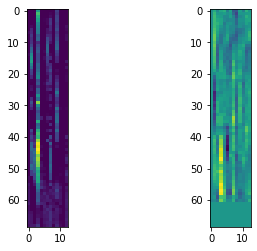

In [27]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[31].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][31].cpu().numpy().T[:, :20])

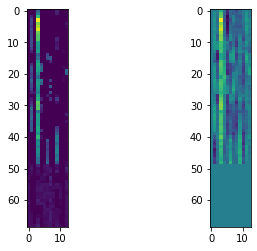

In [28]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[0].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][0].cpu().numpy().T[:, :20])

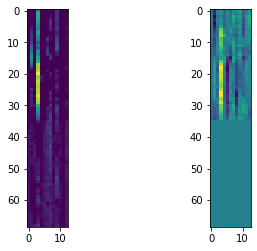

In [29]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[30].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][30].cpu().numpy().T[:, :20])

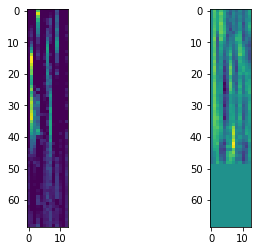

In [30]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[15].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][15].cpu().numpy().T[:, :20])

In [31]:
# %%time

# word2row_idxs_unique_utterances = defaultdict(empty_list)

# for idx, row in df_unique_utterances.iterrows():
#     word2row_idxs_unique_utterances[row.source_word].append(idx)
    
# pd.to_pickle(word2row_idxs_unique_utterances, 'word2row_idxs_unique_utterances_speech2vec_vocab_subset.pkl')

In [32]:
word2row_idxs_unique_utterances = pd.read_pickle('word2row_idxs_unique_utterances_speech2vec_vocab_subset.pkl')

In [33]:
word2embedding = {}

for k, v in word2row_idxs_unique_utterances.items():
    word2embedding[k] = all_embeddings[np.array(v)].mean(0)

In [34]:
word2embedding_without_nans= {}
nans_encountered = 0
for k, v in word2embedding.items():
    if k in vocab and k == k and (not np.isnan(v.numpy()).any()) and not np.all(v.numpy() == 0):
        word2embedding_without_nans[k] = v.numpy()
    else: nans_encountered += 1

print(f'Encountered rows with nan values: {nans_encountered}')

Encountered rows with nan values: 63


In [35]:
from utils import Embeddings

In [36]:
e = Embeddings(
    np.array(list(word2embedding_without_nans.values())).squeeze(1),
    [w.lower() for w in list(word2embedding_without_nans.keys())]
)

In [37]:
for w in ['fast', 'lost', 'small', 'true', 'crazy', 'slow']:
    print(f'{w}: {e.nn_words_to(e[w])}')

fast: ['fast', 'beauty', 'family', 'breast', 'first']
lost: ['lost', 'long', 'happy', 'mind', 'nine']
small: ['small', 'beautiful', 'because', 'nor', 'camp']
true: ['true', 'still', 'coming', 'soon', 'having']
crazy: ['crazy', 'trying', 'town', 'demanded', 'besides']
slow: ['slow', 'harm', 'twice', 'pan', 'hearing']


## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [38]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [39]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [40]:
our_embeddings = Embedding(
    Vocabulary([w.lower() for w in list(word2embedding_without_nans.keys())]),
    np.array(list(word2embedding_without_nans.values())).squeeze(1)
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [41]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 417 words. Will replace them with mean vector
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 66 words. Will replace them with mean vector
Missing 26 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.0405300121518622
Spearman correlation of scores on WS353 -0.05447887366907598
Spearman correlation of scores on SIMLEX999 -0.09640519646394433


In [42]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.5896756323911225
Spearman correlation of scores on WS353 0.49890235673392536
Spearman correlation of scores on SIMLEX999 0.28202624769092116
